# Shallow Water Tides

Building upon our previous analysis of tidal characters and main tidal constituents, this notebook delves into Chapter 5 of the textbook, where you gained insights into tidal propagation in coastal waters and higher harmonic tidal constituents. Here, our primary focus will be on ***shallow-water tides***, also known as ***overtides***, explained in chapter 5.7.5 of the textbook.
Shallow-water tides are generated as a result of non-linear effects in shallow coastal waters and tidal basins. Unlike the basic astronomical constituents driven by tidal forces from the Earth, Moon, and Sun, shallow-water tides have periods that are integer fractions (1/2, 1/3, etc.) of these basic periods. This characteristic gives them the name overtides. We will not repeat the whole theory here, so make sure you followed these weeks lectures and Chapter 5 of the textbook. Some of the overtides are:
- M2 higher harmonics: M3, M4, M6, M8
- S2 higher harmonics: S4, S6, S8
- Tides generated by interaction of different tidal components: MS4, MN4


In this notebook, we will explore overtides using python code and introduce a new method of obtaining the tidal signal and making tidal predictions. Therefore, please import the libraries that we need for the analysis from the cell below.


## Add additional package

This week we have added a new package to the environment. So to run this notebook you will have to install this. You can do this by activating your environment, and then installing the package. The package that we want to install is utide. Because it's a pure Python package, that is not available on the conda channels, we will  install it with pip. 

The commands that you have to run in a miniforge prompt: 
```bash
mamba activate coastal
pip install coastal
```

In [1]:
import pathlib
from pathlib import Path
import sys
import warnings
import ipywidgets as widgets
from ipywidgets import interact
from matplotlib.patches import Patch
from matplotlib.ticker import MaxNLocator, StrMethodFormatter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import xarray as xr
from datetime import datetime, timedelta
from IPython.display import display, Image
import math
import pandas as pd
import pooch
import pickle
from scipy import stats
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    import utide

cwd = pathlib.Path().resolve()
proj_dir = cwd.parent.parent.parent  # this is the root of the CoastalCodeBook
sys.path.append(str(proj_dir))

from initialize.Tide_Initialize import plot_2timeseries_with_interactive_controls, questions_4b

<br><br>
## 1. Visualisation of shallow-water tides

Now that we are familiar with shallow-water tides, we can visualise them. To do this, we will plot the tidal signals at Scheveningen and Jakarta, using the same methodology as in the previous notebooks.

Execute the block below to generate an interactive figure. The figure displays the individual tidal components (upper plot), their combined tidal signal (second plot), and the total tidal signal (third plot) for the two locations.

You can adjust the plotted time range using the slider (from 1 to 15 days) and select which tidal constituents to display with tick boxes. This allows you to experiment with different constituents, observe the resulting signals, and compare the locations.


In [2]:
# Choose tidal constituents
comps = ['M2', 'S2', 'N2', 'K2',  #semi-diurnal
         'K1', 'O1', 'P1', 'Q1',  #diurnal
         'M3', 'M4', 'M6', 'M8', 'S4', 'MN4', 'MS4'] #short period (overtides)

# We choose 15 days to plot
dates = np.array([
    datetime(2000, 1, 1, 0, 0, 0) + timedelta(seconds=item * 3600)
    for item in range(24*15) #15 days
])

# download and load tidal signals
scheveningen_fp = pooch.retrieve(
    "https://coclico.blob.core.windows.net/coastal-dynamics/2_wind_waves_tides/tide_scheveningen.p",
    known_hash="4ebac210fc0893e52655cbc3c9501a6c805e3537f327fed7edb9e7dbfe7fa06a",
)
jakarta_fp = pooch.retrieve(
    "https://coclico.blob.core.windows.net/coastal-dynamics/2_wind_waves_tides/tide_jakarta.p",
    known_hash="7950246c47e757d9dd427063d7c809fda4267ed119efd18de43237aa9f98c9c6",
)
with open(scheveningen_fp, 'rb') as pickle_file:
    scheveningen = pickle.load(pickle_file)
with open(jakarta_fp, 'rb') as pickle_file:
    jakarta = pickle.load(pickle_file)

tide = {
    'Scheveningen': scheveningen,
    'Jakarta': jakarta,
    }

plot_2timeseries_with_interactive_controls(comps, dates, tide)

In [3]:
# Run this cell to get questions
questions_4b()



1. Select components whose period is around 6 hours. Validate your choice with the spectral plot from notebook 2d_tidal_constituents (Tidal Amplitudes chapter).




2. Two important sources for non-linearity in the tidal propagation equations are bottom friction and continuity.
    - Compare the periods of M2 and M3, M4, M6, and M8.
    - Compare the periods of S2 and S4.
    How were these higher harmonics generated? What is the main overtide that is generated as a consequence of the friction depending non-linearly on the tidal velocity?




3. Select components M2 and M4.
    - Are the two constituents in phase? What do you notice in the combined signal?
    - Compare to Fig. 5.71 from the textbook. Determine which panels in Fig. 5.71 best match the signals from Scheveningen and Jakarta. Check if one of them is a combination of two panels.

4. Select the main tidal constituents and compare the resulting combined signal (second plot) to the total tidal signal, which includes the overtides (third plot). What contribution do the overtides have to the total tidal signal?


<br><br>
## 2. Tidal Reconstruction & Prediction

Because the tide is caused by regular astronomical phenomena, it can be predicted accurately a long time ahead (although not including meteorological effects such as storm surges). While we've utilized global model data from FES2014 in our previous analyses, it's important to note that the tidal signal at a particular location can also be derived from measured sea levels through harmonic analysis.

In this part of the notebook, we will analyse the tidal signal obtained from the measured sea level. 
For this, we will use the [utide](https://github.com/wesleybowman/UTide/tree/master) Python package, which is a Python adaptation of the Matlab [UTide](https://nl.mathworks.com/matlabcentral/fileexchange/46523-utide-unified-tidal-analysis-and-prediction-functions) package. It is a unified tidal analysis framework used for carrying out tidal analysis on a multi-year sequence of observations collected at irregularly spaced times. We will again use the [GESLA-3 (Global Extreme Sea Level Analysis)](https://gesla787883612.wordpress.com/) sea level records at Scheveningen.


### Reconstruction

Here we will briefly show how to reconstruct the tidal signal from a measured timeseries. Take a look at the cell below where we do reconstruction and then run it.


In [4]:
tide_gauge_fp = pooch.retrieve(
    "https://coclico.blob.core.windows.net/coastal-dynamics/2_wind_waves_tides/Scheveningen_GESLA.pkl",
    known_hash="90355584803ddcdf88b01fcf02546c4d8201a3fa6f63355ecfdb8ab6a07d1e38",
)
tide_gauge = pd.read_pickle(tide_gauge_fp)


tide_gauge.dropna(inplace=True)
time = tide_gauge.index
    
# Linear regression
t_numeric = np.arange(len(time))
slope, intercept, r_value, p_value, std_err = stats.linregress(t_numeric, tide_gauge)
    
# Detrend the series
detrended_series = tide_gauge - (slope * t_numeric + intercept)
    
# Solve for tidal coefficients
coef = utide.solve(
    time, detrended_series,
    lat=52.099, # latitude of Scheveningen in GESLA
    method='ols',
    nodal=True,
    trend=False,
    conf_int='MC',
)
    
# Reconstruct tidal signal
result = utide.reconstruct(time, coef)
tide = pd.Series(result.h, index=result.t_in)

## This could take several minutes, depending on your computer, so please wait a bit. You will get the following:
#  solve: matrix prep ... solution ... done.
#  prep/calcs ... done.


solve: matrix prep ... solution ... done.
prep/calcs ... done.


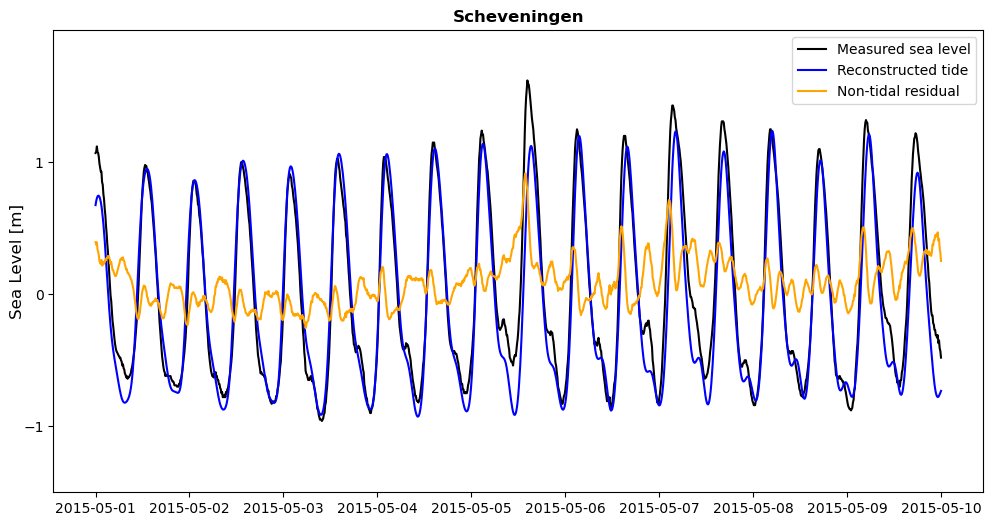

In [6]:
## Plot
# Choose a time window to plot (has to be between 1977 - 2017)
start_date = "2015-05-01 00:00"
end_date = "2015-05-10 00:00"

filtered_tide = tide[start_date:end_date]
filtered_gauge = tide_gauge[start_date:end_date]
var = [filtered_gauge, filtered_tide, filtered_gauge-filtered_tide]
label = ['Measured sea level', 'Reconstructed tide', 'Non-tidal residual']
color = ['black', 'blue', 'orange']
fig, ax = plt.subplots(figsize=(12, 6), sharex=True)
for i in range(len(var)):
    ax.plot(var[i], label=label[i], color=color[i])
    ax.set_ylim(-1.5,2)
    ax.set_yticks([-1, 0, 1])

ax.set_title('Scheveningen', fontsize=12, fontweight='bold')
ax.set_ylabel('Sea Level [m]', ha='center', va='center', rotation='vertical', fontsize=12)
ax.legend(loc='upper right')
plt.show()

<br>
Remember the similar plot from 2d_tidal_constituents. There we asked you if you can try to explain why the tidal signal doesn't perfectly match the observed sea level. This time we could also calculate the non-tidal residual. The non-tidal residual is the part of the sea level that remains once the astronomical tidal component has been removed. This primarily contains the meteorological contribution to sea level, often called the surge. However, it may also contain some non-linear interactions.


<br><br>
### Prediction

Utide can also be used for future simulation of tidal signals. Take a look at the code below and run the cell.

In [7]:
# Simulation dates (feel free to choose your own)
start_date = '2015-01-01'
end_date = '2040-12-31'

d_pred  = pd.date_range(start=start_date, end=end_date, freq='h')

# Predict tidal signal
sim = utide.reconstruct(d_pred, coef)
tide_sim = pd.Series(sim.h, index=sim.t_in)

prep/calcs ... done.


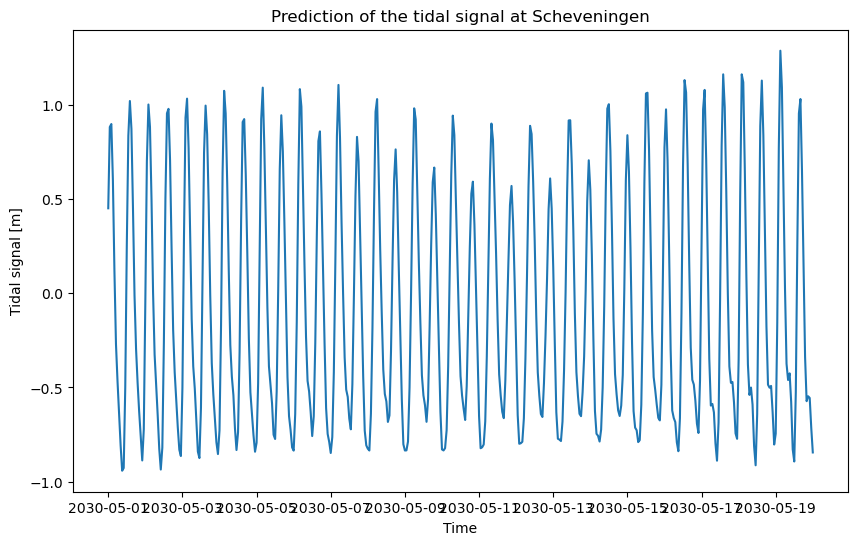


 Now we have the tidal signal for dates in which the observations are not yet available.


In [9]:
## Plot
# Choose a time window to plot (has to be in the interval you choose for prediction)
start_date = "2030-05-01 00:00"
end_date = "2030-05-20 00:00"

filtered_tide_sim = tide_sim[start_date:end_date]

plt.subplots(figsize=(10, 6))
plt.plot(filtered_tide_sim)
plt.title('Prediction of the tidal signal at Scheveningen')
plt.xlabel('Time')
plt.ylabel('Tidal signal [m]')
plt.show()
print('\n Now we have the tidal signal for dates in which the observations are not yet available.')